In [1]:
import os
import re
import datetime as dt

import scipy as sp
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
import suncalc

import rads_extraction
import datetime_tools as dt_extra
from directory_paths import project_dir as pj

date = '2024-01-22'

In [2]:
def init_earth(earth):
    earth.drawcoastlines(color='#555566', linewidth=0.5, zorder=3)

    grid_style = {'linewidth': 0.2, 'dashes':[1,0], 'labels':[1, 1, 1, 1], 'labelstyle':'+/-', 'alpha':0.6}
    earth.drawmeridians(np.arange(-180, 181, 20), **grid_style)
    earth.drawparallels(np.arange(-90, 91, 30), **grid_style)
    
def show_sun_lines(earth):
    lon_arr = np.arange(-180, 180, 20)
    lat_arr = np.zeros(lon_arr.shape)
    day = pd.to_datetime(lon_arr.size*[date])

    df = pd.DataFrame({'date': day, 'lat': lat_arr, 'lon': lon_arr})

    solar_noon = suncalc.get_times(df['date'], df['lon'], df['lat'])['solar_noon']

    solar_noon_sec = [(time.to_pydatetime().replace(tzinfo=None)-dt.datetime(1985, 1, 1)).total_seconds() for time in solar_noon.to_list()] 
    colors = [rads_extraction.set_color(sec) for sec in solar_noon_sec]

    for lon, c in zip(lon_arr, colors):
        earth.drawmeridians(np.array([lon]), color=c, style='.-', linewidth=3)

def show_jason_pos(earth, fpath=r'RADS\\03_22_01_data\\j3_240122.asc'):
    time, lat, lon, sla = rads_extraction.extract_rads(fpath)

    earth.scatter(lon, lat, s=2, c='black', alpha=0.2, marker='.', latlon=True, 
                linewidths=0.001, label=f'jason 3 path', zorder=1)

def plot_file(earth, file, extra=None):

    with open(file, 'r') as f: df = pd.read_table(f, sep=',', header=0, index_col=0)
    lon_array = df['Lon']
    lat_array = df['Lat']
    time_array = df['Time']
    
    avg = np.average([dt_extra.get_sec_since_1985(dt_extra.get_datetime_obj(time_i, inverse=True)) for time_i in time_array])
    color = rads_extraction.set_color(avg)

    earth.scatter(lon_array, lat_array, s=10, c=color, marker='X', latlon=True, 
                linewidths=0.001, label=f'{extra}avg time: {dt_extra.get_time_date(avg)}', zorder=1)

In [3]:
def plot_intensity_line(lon_array, lat_array, val_array, earth=Basemap(), **kwargs):
    # adapted from 'https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html'
    points = np.array([lon_array, lat_array]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(np.min(val_array), np.max(val_array))
    lc = LineCollection(segments, cmap='Spectral', norm=norm)
    # Set the values used for colormapping
    ax = plt.gca()
    lc.set_array(val_array)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    earth.colorbar(line, size='2%', **kwargs)

## CryoSat-2 Analysis

In [4]:
fpath = r'results\final_results\2024-06-06 18.39 - CS2 (pass all) - a=0.9173 b=0.817_raw.csv'

with open(fpath, 'r') as f:
    df = pd.read_table(f, sep=',', header=0, index_col=0)

time_raw = df['Time']
unscaled = df['MIC Unscaled']
MIC = df['MIC']
RADS_GIM = df['RADS GIM']
uncorrected = df['Uncorrected']
lon = df['Lon']
lat = df['Lat']

time = pd.to_datetime(time_raw)


passes = rads_extraction.find_start_passes(os.path.join(pj, fpath), results=True)


(-1.0, 1.0)

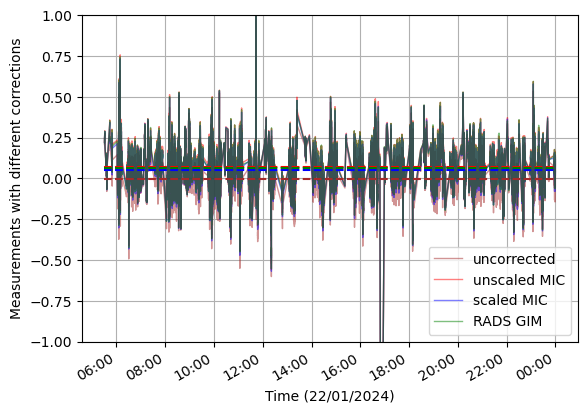

In [5]:
# order = 4
# diff_unscaled_filter = sp.signal.savgol_filter(diff_unscaled, len(diff_unscaled), order)
# diff_IMIC_filter = sp.signal.savgol_filter(diff_IMIC, len(diff_IMIC), order)
# diff_RADS_filter = sp.signal.savgol_filter(diff_RADS, len(diff_RADS), order)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()

main_style = {'alpha': 0.5, 'lw':1}

plt.plot(time, uncorrected, color='brown', label=r'uncorrected', **main_style)
plt.plot(time, unscaled,    color='red', label=r'unscaled MIC', **main_style)
plt.plot(time, MIC,         color='blue', label=r'scaled MIC', **main_style)
plt.plot(time, RADS_GIM,    color='green', label='RADS GIM', **main_style)
plt.hlines(np.average(uncorrected), np.min(time), np.max(time), color='brown', ls='--') #, label='scaled MIC')
plt.hlines(np.average(unscaled)   , np.min(time), np.max(time), color='red', ls='--')#, label=r'unscaled MIC')
plt.hlines(np.average(MIC)        , np.min(time), np.max(time), color='blue', ls='--') #, label='RADS GIM')
plt.hlines(np.average(RADS_GIM)   , np.min(time), np.max(time), color='green', ls='--') #, label='RADS GIM')
plt.plot()
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Time (22/01/2024)')
plt.ylabel('Measurements with different corrections')
plt.ylim((-1, 1))

## Sentinel-3A Analysis

In [6]:
res_dir = os.path.join(pj, 'results', 'final_results')

summary_files = []

for f in os.listdir(res_dir):
    if 'S3A' in f and '.csv' in f:
        summary_files.append(os.path.join(res_dir, f))

pass_n_files = []
offset_MIC_unscaled = []
offset_MIC_scaled = []

for f in summary_files:
    for x in re.split(r'[()]', f):
        if 'pass' in x:
            pass_n_files.append(int(x.strip('pass ')))

    with open(f, 'r') as f:
        df = pd.read_table(f, sep=',', header=0, index_col=0)

    offset_MIC_unscaled.append(np.mean(df['MIC Unscaled'])/np.mean(df['RADS GIM']))
    offset_MIC_scaled.append(np.mean(df['MIC'])/np.mean(df['RADS GIM']))    

offset_S3A = pd.DataFrame(np.array([offset_MIC_scaled, offset_MIC_unscaled]).T, index=pass_n_files, columns=['unscaled', 'MIC'])

better_MIC = offset_S3A[np.abs(offset_S3A['MIC'])<=1].index
better_unscaled = offset_S3A[np.abs(offset_S3A['unscaled'])<1].index
better_RADS = offset_S3A[np.abs(offset_S3A['MIC'])>1].index

Text(0.5, 1.0, 'Paths in which RADS is better')

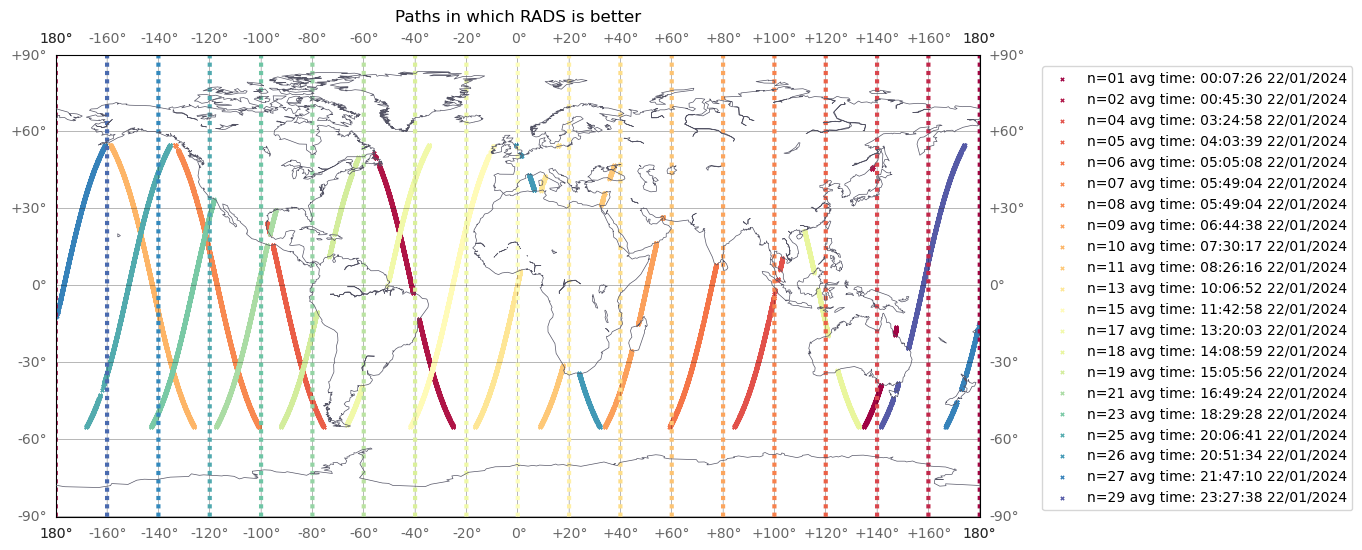

In [7]:
fig, ax = plt.subplots(figsize=(14,6))
earth=Basemap()

init_earth(earth)
show_sun_lines(earth)
# show_jason_pos(earth)

for n in better_RADS:
    file = summary_files[pass_n_files.index(n)]
    plot_file(earth, file, extra=f'n={n:>02} ')

ax.legend(bbox_to_anchor=(1.06, 0.99), loc='upper left')
ax.set_title('Paths in which RADS is better', pad=24)

Text(0.5, 1.0, 'Paths in which MIC is better')

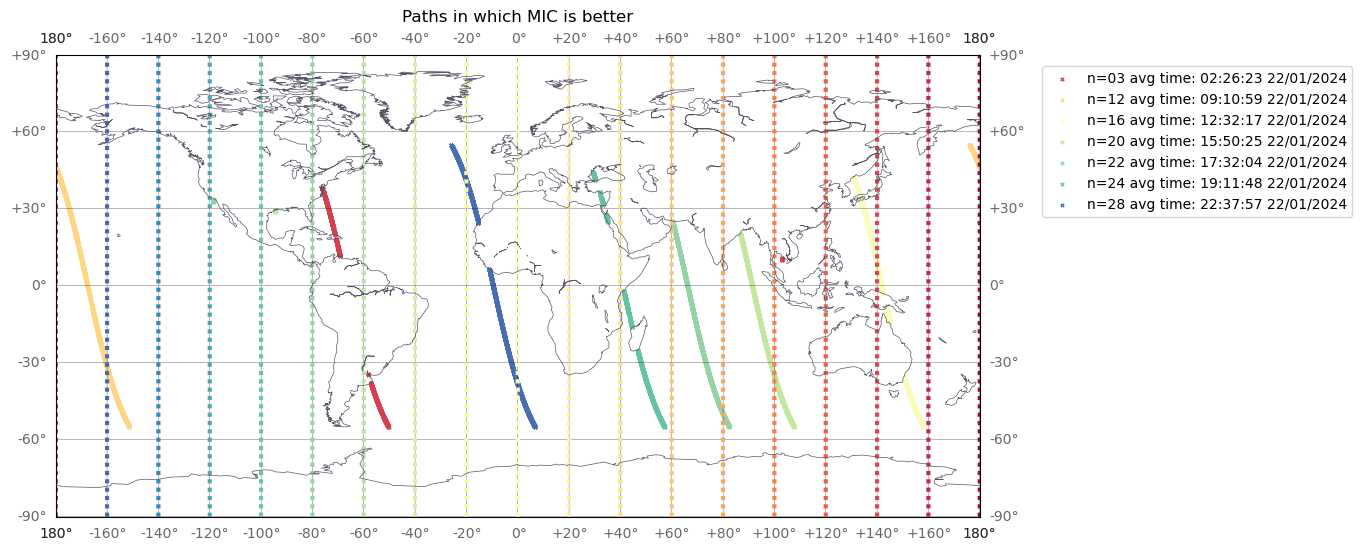

In [8]:
fig, ax = plt.subplots(figsize=(14,6))
earth=Basemap()

init_earth(earth)
show_sun_lines(earth)
# show_jason_pos(earth)

for n in better_MIC:
    file = summary_files[pass_n_files.index(n)]
    plot_file(earth, file, extra=f'n={n:>02} ')

ax.legend(bbox_to_anchor=(1.06, 0.99), loc='upper left')
ax.set_title('Paths in which MIC is better', pad=24)

In [9]:
# getting full dataset

time_raw      = np.ndarray([])
diff_unscaled = np.ndarray([])
diff_MIC     = np.ndarray([])
diff_RADS     = np.ndarray([])
lon           = np.ndarray([])
lat           = np.ndarray([])

for f in summary_files:
    with open(f, 'r') as f:
        df = pd.read_table(f, sep=',', header=0, index_col=0)
    
    time_raw = np.append(time_raw, df['Time'])
    diff_unscaled = np.append(diff_unscaled, df['MIC Unscaled'])
    diff_MIC = np.append(diff_MIC, df['MIC'])
    diff_RADS = np.append(diff_RADS, df['RADS GIM'])
    lat = np.append(lat, df['Lat'])
    lon = np.append(lon, df['Lon'])

time = pd.to_datetime(time_raw)

time          = time[1:-2]
diff_unscaled = diff_unscaled[1:-2]
diff_MIC     = diff_MIC[1:-2]
diff_RADS     = diff_RADS[1:-2]
lon           = lon[1:-2]
lat           = lat[1:-2]

0

Text(0, 0.5, 'Diff w.r.t. dual-frequency measurement')

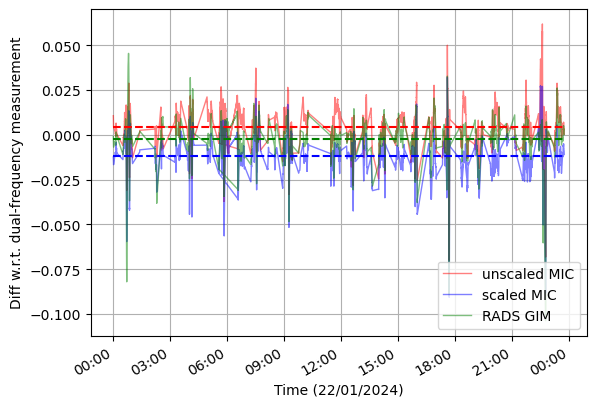

In [10]:
# order = 4
# diff_unscaled_filter = sp.signal.savgol_filter(diff_unscaled, len(diff_unscaled), order)
# diff_IMIC_filter = sp.signal.savgol_filter(diff_IMIC, len(diff_IMIC), order)
# diff_RADS_filter = sp.signal.savgol_filter(diff_RADS, len(diff_RADS), order)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()

main_style = {'alpha': 0.5, 'lw':1}

plt.plot(time, diff_unscaled,        color='red', label=r'unscaled MIC', **main_style)
plt.plot(time, diff_MIC,             color='blue', label=r'scaled MIC', **main_style)
plt.plot(time, diff_RADS,            color='green', label='RADS GIM', **main_style)
plt.hlines(np.average(diff_unscaled), np.min(time), np.max(time), color='red', ls='--')#, label=r'unscaled MIC')
plt.hlines(np.average(diff_MIC), np.min(time),      np.max(time), color='blue', ls='--') #, label='scaled MIC')
plt.hlines(np.average(diff_RADS), np.min(time),     np.max(time), color='green', ls='--') #, label='RADS GIM')
plt.plot()
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Time (22/01/2024)')
plt.ylabel('Diff w.r.t. dual-frequency measurement')